In [10]:
import torch
import torchvision
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image
import tqdm
import datasets
from utils import get_params_count_summary
import json
import time
import copy

import pprint
pp = pprint.PrettyPrinter(width=128, compact=True)
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "4"
DEVICE = "cuda"

import sys
sys.path.append('segmentation/')
from segmentation import Segmenter, visualized_masks


import datasets
from data.sharegpt4v import ShareGPT4V
from data.clevr import CLEVR

from transformers import CodeGenTokenizerFast
import cv2
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
import pycocotools.mask as mask_util
import pickle
from model.multimodal_tokenizer import MultimodalTokenizer

from transformers import (
    TrainingArguments,
    Trainer
)
from peft import LoraConfig, PeftModel, get_peft_model


### Model

In [11]:
# Patch 32x32
patch_size = 32
max_seg_per_img = 150  
square_patches = True
ckpt = "/home/dchenbs/workspace/Seq2Seq-AutoEncoder/runs/phi-2-multimodal/patchlmm-32-clevr-full-5ep-lora(32)-bs64-lr1e-4/checkpoint-2000"

# # Patch 80x80
# patch_size = 80
# max_seg_per_img = 24 
# square_patches = True
# ckpt = "/home/dchenbs/workspace/Seq2Seq-AutoEncoder/runs/phi-2-multimodal/patchlmm-80-clevr-full-5ep-lora(32)-bs64-lr1e-4/checkpoint-2000"

# # segment seqae-based
# square_patches = False
# max_seg_per_img = 32
# ckpt = "/home/dchenbs/workspace/Seq2Seq-AutoEncoder/runs/phi-2-multimodal/seglmm-clevr-full-5ep-lora(32)-bs32-lr1e-4/checkpoint-200"


if square_patches:
    segmenter = Segmenter(model_name='square_patches', patch_size=patch_size, do_mask_expansion=False)
else:
    segmenter = None

# with open('segmentation/mobile_sam_v2_l2.json', 'r') as f:
#     config = json.load(f)
#     pprint.pprint(config)
# segmenter = Segmenter(config['model_name'], config['checkpoint'], **config['kwargs'])


In [12]:

from model.seq2seq_autoencoder import Seq2SeqAutoEncoderModel
from model.modeling_multimodal_phi import PhiForMultimodalModeling, load_seqae

model = PhiForMultimodalModeling.from_pretrained(
    "microsoft/phi-2",
    w_segment_loss=1.0,
    w_bbox_loss=1/(1000*1000),
    seqae_batch_size=32,
    )

seqae = Seq2SeqAutoEncoderModel.from_pretrained('/home/dchenbs/workspace/Seq2Seq-AutoEncoder/runs/Jan02_11-49-33_host19-SA1B-[327MB-16queries-1024]-[lr1e-05-bs16x1step-8gpu]/checkpoints/checkpoint_step4350k')
seqae.enable_caching_latents(
    cache_dir='segmentation/cached_segments/seqae_cache_dir',
    use_existing=True
    )
load_seqae(model, seqae)

peft_model = PeftModel.from_pretrained(model, ckpt, from_transformers=True)

state_dict = torch.load(ckpt+'/additional_modules.pth', map_location="cpu")
message = peft_model.load_state_dict(state_dict, strict=False)

model = peft_model.merge_and_unload()
model = model.to(DEVICE)


Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  2.17it/s]


Loaded 384000 latents from segmentation/cached_segments/seqae_cache_dir/cached_latents.pkl
Latent caching enabled, cache limit: 1000000


### Tokenizer

In [13]:
tokenizer = MultimodalTokenizer.from_pretrained(
    "microsoft/phi-2", trust_remote_code=True, 
    segmenter=segmenter, 
    seqae_config=model.seqae.config, 
    max_seg_per_img=max_seg_per_img,
    model_max_length=max_seg_per_img+100,
    )

if not square_patches:
    tokenizer.load_cached_segments(
        # '/home/dchenbs/workspace/Seq2Seq-AutoEncoder/segmentation/cached_segments/sharegpt4v_instruct_gpt4-vision_cap100k')
        '/home/dchenbs/workspace/Seq2Seq-AutoEncoder/segmentation/cached_segments/clevr_val')

model.special_token_id_mapping = {
    "<|startofimage|>": tokenizer.convert_tokens_to_ids("<|startofimage|>"),
    "<|endofimage|>": tokenizer.convert_tokens_to_ids("<|endofimage|>"),
    "<|seg|>": tokenizer.convert_tokens_to_ids("<|seg|>"),
    "<|endoftext|>": tokenizer.convert_tokens_to_ids("<|endoftext|>"),
    "[PAD]": tokenizer.convert_tokens_to_ids("[PAD]"),
}

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'CodeGenTokenizer'. 
The class this function is called from is 'MultimodalTokenizer'.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


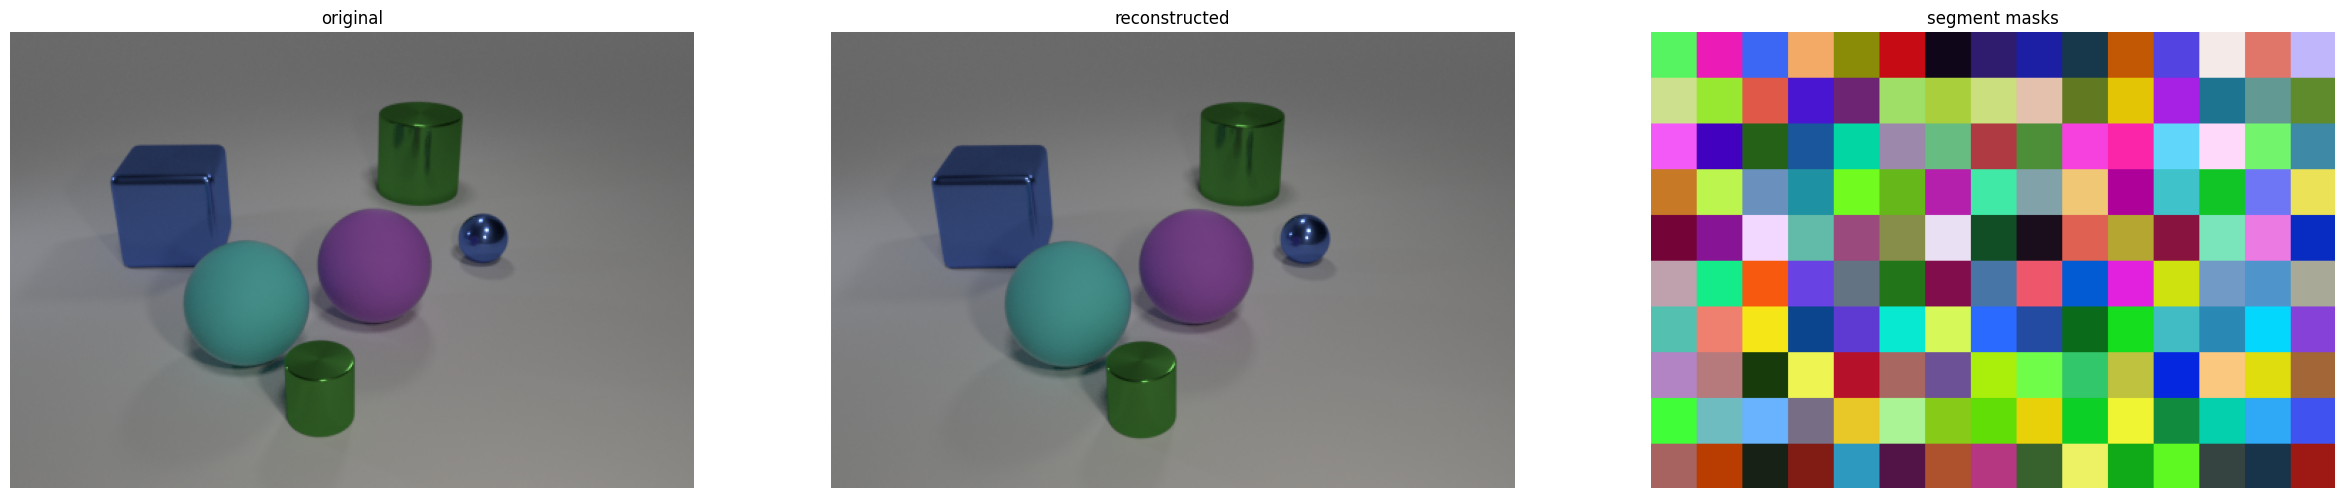

In [14]:
root = '/home/dchenbs/workspace/datasets/CLEVR_v1.0/images/val'
images = os.listdir(root)
image_path = os.path.join(root, random.choice(images))

plt.figure(figsize=(30, 10))
image = Image.open(image_path)

plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title('original')
plt.axis('off')

inputs  = tokenizer([f'<img_path>{image_path}</img_path>'], return_tensors="pt")

canvas = tokenizer.decode_image(inputs['segment_sequences'][0][0], inputs['bboxes'][0][0])
plt.subplot(1, 3, 2)
plt.imshow(canvas)
plt.title('reconstructed')
plt.axis('off')

canvas = tokenizer.decode_image(inputs['segment_sequences'][0][0], inputs['bboxes'][0][0], filling='random')
plt.subplot(1, 3, 3)
plt.imshow(canvas)
plt.axis('off')
plt.title('segment masks')
plt.show()

### Data

In [15]:

# dataset_path = '/home/dchenbs/workspace/datasets/sharegpt4v/ShareGPT4V'
# dataset_identifier = 'sharegpt4v_instruct_gpt4-vision_cap100k'

dataset_path = '/home/dchenbs/workspace/datasets/CLEVR_v1.0'
dataset_identifier = 'clevr_val'

if 'sharegpt4v' in dataset_identifier:
    annotation_file = os.path.join(dataset_path, dataset_identifier+'.json')
    dataset = ShareGPT4V(annotation_file, split='val')
    failed_samples = dataset.validate_exist(valid_img_paths=tokenizer.cache)
    
elif 'clevr' in dataset_identifier:
    split = dataset_identifier.split('_')[-1]
    dataset = CLEVR(dataset_path=dataset_path, split=split)
    # failed_samples = dataset.validate_exist(valid_img_paths=tokenizer.cache)

In [16]:
all_gt = []
all_pred = []



for i in tqdm.tqdm(range(100)):
    sample_idx = i

    prompt, target = dataset[sample_idx].split('### AI: \n')

    inputs  = tokenizer([
        prompt
        ], return_tensors="pt", return_attention_mask=False, padding=True)

    inputs['input_ids'] = inputs['input_ids'].to(DEVICE)
    inputs['segment_sequences'] = [segment_sequence.to(DEVICE) for segment_sequence in inputs['segment_sequences']]
    inputs['bboxes'] = [bbox.to(DEVICE) for bbox in inputs['bboxes']]

    outputs = model.generate(
        # **inputs, 
        input_ids=inputs['input_ids'],
        segment_sequences=inputs['segment_sequences'],
        bboxes=inputs['bboxes'],
        use_cache=False,
        max_length=512)
    text = tokenizer.batch_decode(outputs)[0]
    
    # img_path = dataset.__getitem__(sample_idx, only_return_img_path=True)
    # img = Image.open(img_path)
    # plt.imshow(img)
    # plt.axis('off')
    # plt.show()
    # print(text)
    # print(f'### GT:\n{target}')

    all_gt.append(target)
    all_pred.append(text.split('### AI: \n')[1])

  0%|          | 0/100 [00:00<?, ?it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
  1%|          | 1/100 [00:09<15:04,  9.14s/it]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
  2%|▏         | 2/100 [00:18<14:57,  9.16s/it]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
  3%|▎         | 3/100 [00:27<14:50,  9.18s/it]The attention mask and the pad token id were not set. As a conseque

In [ ]:
import re

def parse_caption(caption):

    # example caption: Total 5 objects: a large brown rubber cylinder, a small green rubber cylinder, a large gray rubber cube, a large purple metal sphere, a small gray metal cube.<|endoftext|>

    count, objects_size, objects_color, objects_material, objects_shape = None, None, None, None, None

    try:
        count = int(re.search(r'Total (\d+) objects', caption).group(1))
        objects = re.findall(r'a (\w+) (\w+) (\w+) (\w+)', caption)

        objects_size = [obj[0] for obj in objects]
        objects_color = [obj[1] for obj in objects]
        objects_material = [obj[2] for obj in objects]
        objects_shape = [obj[3] for obj in objects]
        success = True
    except:
        success = False

    return success, count, objects_size, objects_color, objects_material, objects_shape

def evaluate_clevr(all_gt, all_pred):
    # get number of parsable predicted captions (success rate)
    # get accuracy of each attribute

    parsable_captions = 0
    parsable_objects = 0

    counting_correct = 0
    size_correct = 0
    color_correct = 0
    material_correct = 0
    shape_correct = 0
    
    for gt, pred in zip(all_gt, all_pred):
        _, num_objs, objects_size, objects_color, objects_material, objects_shape = parse_caption(gt)
        success, pred_num_objs, pred_objects_size, pred_objects_color, pred_objects_material, pred_objects_shape = parse_caption(pred)

        # print(_, num_objs, objects_size, objects_color, objects_material, objects_shape)
        # print(success, pred_num_objs, pred_objects_size, pred_objects_color, pred_objects_material, pred_objects_shape)
        
        if success:
            parsable_captions += 1
            if num_objs == pred_num_objs:
                counting_correct += 1
            for i in range((min(len(pred_objects_size), len(objects_size)))):
                if objects_size[i] == pred_objects_size[i]:
                    size_correct += 1
                if objects_color[i] == pred_objects_color[i]:
                    color_correct += 1
                if objects_material[i] == pred_objects_material[i]:
                    material_correct += 1
                if objects_shape[i] == pred_objects_shape[i]:
                    shape_correct += 1
                parsable_objects += 1

    parsable_rate = parsable_captions / len(all_gt)
    counting_acc = counting_correct / parsable_captions
    size_acc = size_correct / parsable_objects
    color_acc = color_correct / parsable_objects
    material_acc = material_correct / parsable_objects
    shape_acc = shape_correct / parsable_objects

    return {
        'evaluated_captions': len(all_gt),
        'parsable_rate': parsable_rate,
        'counting_acc': counting_acc,
        'size_acc': size_acc,
        'color_acc': color_acc,
        'material_acc': material_acc,
        'shape_acc': shape_acc
    }

evaluation = evaluate_clevr(all_gt, all_pred)
print(evaluation)

results = {
    'evaluation': evaluation,
    'all_gt': all_gt,
    'all_pred': all_pred,
}

json.dump(results, open(ckpt+'/evaluations.json', 'w'), indent=4)

{'evaluated_captions': 100, 'parsable_rate': 1.0, 'counting_acc': 0.15, 'size_acc': 0.5777385159010601, 'color_acc': 0.12897526501766785, 'material_acc': 0.48056537102473496, 'shape_acc': 0.3674911660777385}
